In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
import pandas as pd


from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report
from sklearn.model_selection import RandomizedSearchCV


# Repeat the prior data mining example to identify the top 10 long/short trades
# using the last 10 years. But apply ML to determine whether we should actually
# take up those trades proposed by the seasonal strategy. In this case,
# conditional on a signal, assign a 1 or 0 if the strategy would have yielded
# a return of at least 1% (to roughly account for slippage or bid/ask spread)
# and use a random forest to predict, based off of a number of indicators:
# 1) Other seasonal indicators: Winrate for last year, last 3 yrs, last 5 yrs
# 2) Estimate of daily volatility (EWM with span parameter = 30)
# 3) Simple momentum indicator for the stock and the SP500 overall: 'up'
#    if EWM with span of 5 (1 week) exceeds the EWM with span of 10 (2 weeks)
# 4) Returns relative to yesterday's price, for stock and SP500 overall


def seasonal_return(data, symbol, start_date, end_date, first_year, last_year):
    data_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue
        returns = log(end_price / start_price)
        data_list.append([symbol, year, trade_start_date, start_price,
                          trade_end_date,
                          end_price, returns])

    df = pd.DataFrame(data_list, columns=['Symbol', 'Year', 'Init Date',
                                          'Init Price', 'Final Date', 'Final Price', 'Return'])
    return df


def return_stats(x, risk_free_rate=0):
    d = {}
    d['N'] = x['Symbol'].count()
    d['avg r'] = x['Return'].mean()
    d['vol'] = x['Return'].std()
    downsides = x[x['Return'] < risk_free_rate]['Return']
    d['downside dev'] = 0 if downsides.count() == 0 else downsides.std()
    upsides = x[-x['Return'] < risk_free_rate]['Return']
    d['upside dev'] = 0 if upsides.count() == 0 else upsides.std()
    d['up'] = sum(x['Return'] > risk_free_rate)
    return pd.Series(d, index=['N', 'avg r', 'vol', 'downside dev', 'upside dev',
                               'up'])


# Historical rate of stock going up (i.e. winrate if we are long)
def historical_up_rate(data, symbol, start_date, end_date, first_year, last_year):
    up_list = []
    # Deal with Feb 29: assign start/end dates to Mar 1
    if start_date == '02-29': start_date = '03-01'
    if end_date == '02-29': end_date = '03-01'
    for year in range(first_year, (last_year + 1)):
        full_start_date = str(year) + '-' + start_date
        full_end_date = str(year) + '-' + end_date
        trade_start_date = data.loc[full_start_date, 'Price Date']
        trade_end_date = data.loc[full_end_date, 'Price Date']
        start_price = data.loc[full_start_date, symbol]

        # If price data is missing, skip that year
        if np.isnan(start_price):
            continue
        end_price = data.loc[full_end_date, symbol]
        if np.isnan(end_price):
            continue

        if end_price >= start_price:
            ret = 1
        else:
            ret = 0
        up_list.append(ret)
    return np.mean(up_list)


# Identify long and short positions using the same seasonal strategy/criteria,
# using the 10-year seasonal lookback, but conducting the trades over
# 2019-2021. We will look at seasonal activity going back to 2009.

# Pull S&P500 Data

# Pull the adjusted close prices off Yahoo Finance
df = pd.read_csv("S&P500-Symbols.csv")
tickers = list(df['Symbol'])
start_date = '1989-01-01'
end_date = '2024-01-03'  # Get data a few days past end of year to backfill

# Either pull from Yahoo finance, or for read the pre-downloaded CSV
# data = pd.DataFrame(yf.download(tickers, start_date, end_date)['Adj Close'])
# data.reset_index().to_csv("S&P500-adjusted-close.csv", index=False)
data = pd.read_csv('S&P500-adjusted-close.csv')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
all_dates = pd.date_range(start_date, end_date)
data['Price Date'] = data.index

# Backfill with trading prices for missing dates
data = data.reindex(all_dates, method='bfill')
sp500_dates_added = pd.read_csv("S&P500-Info.csv")[['Symbol', 'Date added']]
all_stocks = data.columns.drop(labels='Price Date')
data = data[data.index < '2024-01-01']

# Restrict to stocks that have data back in 2009, total of 432
sub_cols = data.columns[data.loc['2009-01-01'].notna()]
sub_cols = sub_cols.append(pd.Index(['Price Date']))
sub_stocks = data[sub_cols].columns.drop(labels='Price Date')
sub_data = data[sub_cols][data.index >= '2009-01-01']

# Specifications for the technical strategy
hold_range = [7, 14, 28]  # hold for 1, 2, or 4 weeks
delay_range = [0, 5, 10]  # search for trades 0, 5, 10 days after trade window

# Trade windows start on the 1st/15th of each month
start_months = list(range(1, 12 + 1))
start_days = ['-01', '-15']
initial_dates = [str(i) + j for i, j in product(start_months, start_days)]


In [ ]:
# Do this one time for each year in 2019 to 2021. Takes about 20 minutes per
# year: DO NOT RUN and import the CSV file afterwards instead
all_returns_list = []

for trade_year in [2019, 2020, 2021]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:

        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        # This technically means we will never start a position on the 29-31st
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year + timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(seasonal_return(
                        sub_data, stock,start_calendar, end_calendar,
                        start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime('%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = symbol_stats['avg r'] / symbol_stats['vol']
                symbol_stats['Sharpe Short'] = -symbol_stats['avg r'] / symbol_stats['vol']
                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

all_returns = pd.concat(all_returns_list)

In [2]:
# Import the CSV of all returns
all_returns = pd.read_csv('seasonal_trades_2019_2021.csv')

# Annualize returns
all_returns['annualized r'] = (all_returns['avg r'] * 365 /
                               all_returns['hold length'])

all_returns['trade year'] = all_returns['trade window'].str.slice(0, 4)

# Consider first only the long positions
# This time, our criteria is an annualized return > 50%, 6/10+ winrate in the
# last 10 years, and total return of at least 1% (to account for transaction
# costs). From here, sort by highest Sharpe ratio using historical seasonal
# trades, and select the top 10 for each trade window

long_positions = all_returns[
(all_returns['annualized r'] > 0.5) & (all_returns.up >= 6) &
(all_returns['avg r'] > .01)].sort_values('Sharpe Long', ascending=False
    ).groupby('trade window').head(10)

# Define the feature functions, keeping in mind that all_returns already has
# the seasonal data calculated

# Historical winrates
long_positions['past1yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 1, int(row['trade year']) - 1), axis=1)

long_positions['past3yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 3, int(row['trade year']) - 1), axis=1)

long_positions['past5yr'] = long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'], row['start date'][5:10], row['end date'],
    int(row['trade year']) - 5, int(row['trade year']) - 1), axis=1)

# Daily volatility with exponentially weighted moving average
# We get in a bit of trouble with the backfilled data: it would result in
# repetitions of the same price over non-trading days, reducing volatility,
# so move forward to the day we would trade and then only consider averages of
# actual trading days

data_no_backfill = data[data.index == data['Price Date']]


# Note that these functions are shifted by 1, since it would involve knowing
# the current day's closing price (assume we trade DURING the day and take the
# then unknown close price)

def get_ewm_vol(data, symbol, date, span=30):
    stock_rets = np.log(data[symbol] / data[symbol].shift(1)).shift(1)
    return stock_rets.ewm(span).std().loc[date]


long_positions['ewm_vol'] = long_positions.apply(lambda row: get_ewm_vol(
    data_no_backfill, row['Symbol'], data.loc[row['start date']]['Price Date'],
    30), axis=1)


# EWMA of simple price: compare between a long/short window to determine
# whether the signal is long (if the short window's EWMA > longer window's,
# implying recent price movements are upwards)
def get_ewm_momentum(data, symbol, date, long_window, short_window):
    short_ewma = data[symbol].ewm(short_window).mean().shift(1).loc[date]
    long_ewma = data[symbol].ewm(long_window).mean().shift(1).loc[date]
    return np.log(short_ewma / long_ewma)


long_positions['long_momentum'] = long_positions.apply(lambda row:
                                                       get_ewm_momentum(data_no_backfill, row['Symbol'],
                                                                        data.loc[row['start date']]['Price Date'],
                                                                        long_window=10, short_window=5), axis=1)


def get_recent_return(data, symbol, date, days_back=1):
    return np.log(data[symbol] / data[symbol].shift(days_back)).shift(1).loc[date]


long_positions['yesterday_ret'] = long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)


In [3]:
# Get SP500 EWMA and yesterday returns, making sure not to backfill

# Import SP500 data
spx = pd.DataFrame(yf.download('^SPX', start_date, end_date)['Adj Close'])
all_dates = pd.date_range(start_date, end_date)

long_positions['sp500_ewm_vol'] = long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],10), axis=1)

long_positions['sp500_ewma'] = long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
     data.loc[row['start date']]['Price Date'], 
     long_window=10, short_window=5), axis=1)

long_positions['sp500_yest_ret'] = long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],
        days_back=1), axis=1)


# Get the actual returns for the start/end date

def get_actual_return(data, symbol, start_date, end_date):
    return np.log(data[symbol].loc[end_date] / data[symbol].loc[start_date])


long_positions['actual_return'] = long_positions.apply(
    lambda row: get_actual_return(data, row['Symbol'], row['start date'],
        row['trade year'] + '-' + row['end date']), axis=1)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Assign 1 or 0 for whether or not we should have traded:
# this is the outcome variable we will train the features to predict

# Here, due to the presence of slippage, let's restrict to at least a 1%
# absolute return. Even in that case, 358/720 long trades would have absolute
# returns over 1%, i.e. ~50% of the trades. Notably, the average return across
# all 720 trades (3 years x 12 months x 2 trade windows x 10 trades/window) is
# still profitable, with average return of 0.78% per trade

long_positions['outcome'] = np.where(
    long_positions['actual_return'] > 0.01, 1, 0)

# long_positions['actual_return'].mean()

# Implement Random Forest

X = long_positions[['past1yr', 'past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y = long_positions['outcome'].values

# Split data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.75, shuffle=False, random_state = np.random.seed(5555))

model = RandomForestClassifier(random_state = np.random.seed(5555))

model.fit(X_train,y_train)

RandomForestClassifier()

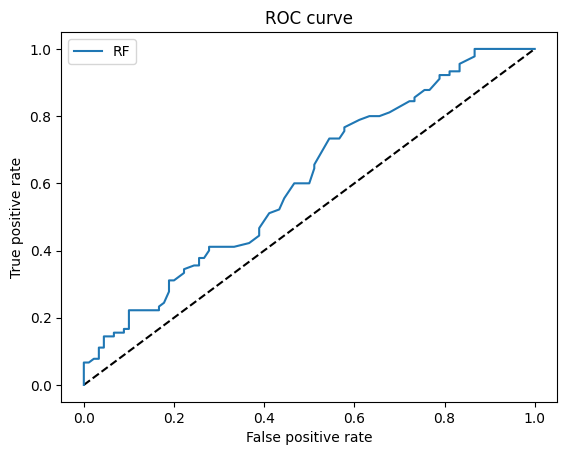

              precision    recall  f1-score   support

    no_trade       0.55      0.59      0.57        90
       trade       0.55      0.51      0.53        90

    accuracy                           0.55       180
   macro avg       0.55      0.55      0.55       180
weighted avg       0.55      0.55      0.55       180

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00        90
   trade_no_ML       0.50      1.00      0.67        90

      accuracy                           0.50       180
     macro avg       0.25      0.50      0.33       180
  weighted avg       0.25      0.50      0.33       180



c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [5]:
# Generate a ROC curve as well as some classification reports
# The ROC curve is generally above y=x (which we would hope would be the case!)
# suggesting that our overlaid ML model has some power when it comes to
# distinguishing between profitable and not profitable long trades of the ones
# suggested by the simple seasonal strategy

y_pred_rf = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_test, y_pred,
                            target_names=['no_trade', 'trade']))

print(classification_report(y_test, np.repeat(1, len(y_test)),
                            target_names=['no_trade_no_ML', 'trade_no_ML']))

In [19]:
# Part 3: Applying the model out of sample
# Now let's apply this model to 2022 and 2023, which were bearish/bullish years
# overall, and out of the training sample (2019-2021).

# DO NOT RUN the below, and instead read the CSV file
later_returns_list = []

for trade_year in [2022, 2023]:
    start_year = trade_year - 10
    end_year = trade_year - 1

    for initial_date in initial_dates:

        initial_calendar_year = datetime.strptime(
            str(trade_year) + "-" + initial_date, "%Y-%m-%d")

        # Delay refers to how many days after the 1st or 15th we start the trade
        # This technically means we will never start a position on the 29-31st
        for delay in delay_range:
            start_calendar_year = initial_calendar_year + timedelta(days=delay)
            start_calendar = start_calendar_year.strftime('%m-%d')

            for hold_length in hold_range:
                end_calendar = (start_calendar_year+timedelta(days=hold_length)
                                ).strftime('%m-%d')
                stock_returns_list = []

                for stock in sub_stocks:
                    stock_returns_list.append(
                        seasonal_return(sub_data, stock,start_calendar,
                            end_calendar, start_year, end_year))

                seasonal_returns = pd.concat(stock_returns_list)
                symbol_stats = seasonal_returns.groupby('Symbol').apply(
                    return_stats, risk_free_rate=0)
                symbol_stats['trade window'] = initial_calendar_year.strftime(
                    '%Y-%m-%d')
                symbol_stats['start date'] = start_calendar_year
                symbol_stats['end date'] = end_calendar
                symbol_stats['Sharpe Long'] = symbol_stats['avg r'] / symbol_stats['vol']
                symbol_stats['Sharpe Short'] = -symbol_stats['avg r'] / symbol_stats['vol']

                symbol_stats['hold length'] = hold_length
                all_returns_list.append(symbol_stats)

later_returns = pd.concat(all_returns_list)

# Annualize returns
later_returns['annualized r'] = (all_returns['avg r'] * 365 /
                                 all_returns['hold length'])

0.007761101553680079

In [6]:
# Read in seasonal long trades identified for 2022/2023
later_returns = pd.read_csv('seasonal_trades_2022_2023.csv')

later_long_positions = later_returns[(later_returns['annualized r'] > 0.5) &
                                     (later_returns.up >= 6) & later_returns['avg r'] > .01].sort_values(
    'Sharpe Long', ascending=False).groupby('trade window').head(10)

# Calculate the feature values

later_long_positions['past1yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-1,int(row['trade year'])-1), axis = 1)

later_long_positions['past3yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-3,int(row['trade year'])-1), axis = 1)

later_long_positions['past5yr']=later_long_positions.apply(lambda row: historical_up_rate(
    data, row['Symbol'],row['start date'][5:10], row['end date'], 
    int(row['trade year'])-5,int(row['trade year'])-1), axis = 1)


later_long_positions['ewm_vol'] = later_long_positions.apply(
    lambda row: get_ewm_vol(data, row['Symbol'], row['start date'], 30), axis=1)

later_long_positions['long_momentum'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(data, row['Symbol'], row['start date'],
        long_window=10, short_window=5), axis=1)

later_long_positions['yesterday_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(data_no_backfill, row['Symbol'],
                                  data.loc[row['start date']]['Price Date'],
                                  days_back=1), axis=1)

later_long_positions['sp500_ewm_vol'] = long_positions.apply(
    lambda row: get_ewm_vol(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'],10), axis=1)

later_long_positions['sp500_ewma'] = later_long_positions.apply(
    lambda row: get_ewm_momentum(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], long_window=10,
        short_window=5), axis=1)

later_long_positions['sp500_yest_ret'] = later_long_positions.apply(
    lambda row: get_recent_return(spx, 'Adj Close',
        data.loc[row['start date']]['Price Date'], days_back=1), axis=1)

later_long_positions['actual_return'] = later_long_positions.apply(
    lambda row: get_actual_return(data, row['Symbol'], row['start date'],
        str(row['trade year']) + '-' + row['end date']), axis=1)


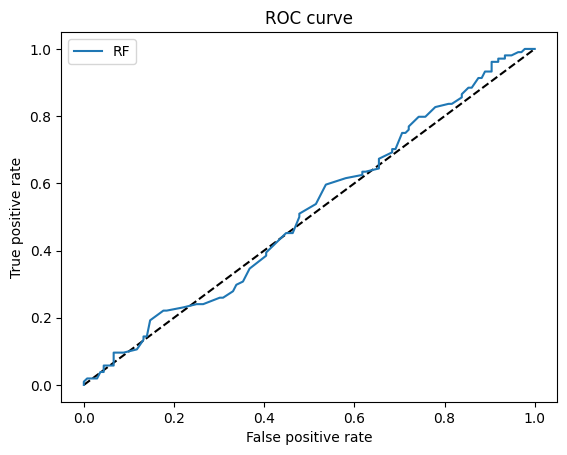

              precision    recall  f1-score   support

    no_trade       0.60      0.46      0.52       136
       trade       0.46      0.60      0.52       104

    accuracy                           0.52       240
   macro avg       0.53      0.53      0.52       240
weighted avg       0.54      0.52      0.52       240

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00       136
   trade_no_ML       0.43      1.00      0.60       104

      accuracy                           0.43       240
     macro avg       0.22      0.50      0.30       240
  weighted avg       0.19      0.43      0.26       240



c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [8]:
# Fit the model on all of X and y, i.e. data from 2019-2021, to predict for 2022
model = RandomForestClassifier(random_state = np.random.seed(5555))
model.fit(X, y)

long_2022 = later_long_positions[later_long_positions['trade year'] == 2022]
X_2022 = long_2022[['past1yr', 'past3yr', 'past5yr','ewm_vol', 'long_momentum',
                    'yesterday_ret','sp500_ewm_vol', 'sp500_ewma',
                    'sp500_yest_ret']].values
y_2022 = np.where(long_2022['actual_return'] > 0.01, 1, 0)

rf_trade_2022_prob = model.predict_proba(X_2022)[:, 1]
rf_trade_2022 = model.predict(X_2022)
fpr_rf, tpr_rf, _ = roc_curve(y_2022, rf_trade_2022_prob)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_2022, rf_trade_2022,
                            target_names=['no_trade', 'trade']))

print(classification_report(y_2022, np.repeat(1, len(y_2022)),
                            target_names=['no_trade_no_ML', 'trade_no_ML']))

In [16]:
# As before, this model results in an improvement in the precision of trades,
# from 43% to 51%, but with a slight decrease in average returns (0.13%) to
# (0.33%). However, these differences in average are not statistically
# significant: the standard deviation of observed returns is ~6.9%. Maybe the
# conclusion is that this seasonal long strategy will suffer in a bearish year.

long_2022['actual_return'].std()
long_2022[rf_trade_2022==1]['actual_return'].std()

0.06746198714438009

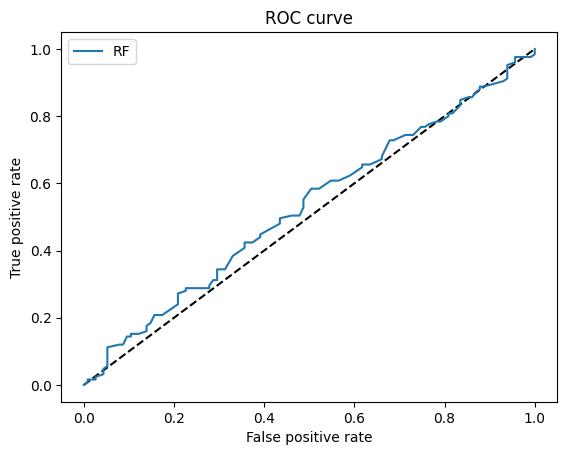

              precision    recall  f1-score   support

    no_trade       0.49      0.90      0.64       115
       trade       0.61      0.15      0.24       125

    accuracy                           0.51       240
   macro avg       0.55      0.52      0.44       240
weighted avg       0.56      0.51      0.43       240

                precision    recall  f1-score   support

no_trade_no_ML       0.00      0.00      0.00       115
   trade_no_ML       0.52      1.00      0.68       125

      accuracy                           0.52       240
     macro avg       0.26      0.50      0.34       240
  weighted avg       0.27      0.52      0.36       240



c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\users\ray\documents\github\technical-trading\venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [55]:
# For 2023, add the data from 2019-2021 to that from 2022 to generate the
# features and fit the model, which will be used to predict results in 2023

long_positions_to_2023 = pd.concat([long_positions,
    later_long_positions[later_long_positions['trade year'] == 2022]])
long_positions_to_2023['outcome'] = np.where(long_positions_to_2023['actual_return'] > 0.01, 1, 0)

X_to_2023 = long_positions_to_2023[['past1yr', 'past3yr', 'past5yr', 'ewm_vol',
'long_momentum', 'yesterday_ret','sp500_ewm_vol', 'sp500_ewma', 'sp500_yest_ret']].values
y_to_2023 = long_positions_to_2023['outcome'].values

model = RandomForestClassifier(random_state = np.random.seed(5555))

model.fit(X_to_2023, y_to_2023)

# Predict 2023 outcomes
long_2023 = later_long_positions[later_long_positions['trade year']== 2023]
X_2023 = long_2023[['past1yr', 'past3yr', 'past5yr', 'ewm_vol', 'long_momentum',
                    'yesterday_ret', 'sp500_ewm_vol','sp500_ewma',
                    'sp500_yest_ret']].values
y_2023 = np.where(long_2023['actual_return'] > 0.01, 1, 0)


rf_trade_2023_prob = model.predict_proba(X_2023)[:, 1]
rf_trade_2023 = model.predict(X_2023)
fpr_rf, tpr_rf, _ = roc_curve(y_2023, rf_trade_2023_prob)


plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_2023, rf_trade_2023,
                            target_names=['no_trade', 'trade']))

print(classification_report(y_2023, np.repeat(1, len(y_2023)),
                            target_names=['no_trade_no_ML', 'trade_no_ML']))

In [19]:
print(long_2023['actual_return'].mean())
print(long_2023['actual_return'].std())
print(long_2023['actual_return'].count())


0.01620860773238088
0.05441409720081515
240


In [20]:
print(data_2023[rf_trade_2023==1]['actual_return'].mean())
print(data_2023[rf_trade_2023==1]['actual_return'].std())
print(data_2023[rf_trade_2023==1]['actual_return'].count())


0.02861771029823806
0.05999621557200754
31


In [45]:
all_2022_2023 = pd.concat([long_2022,data_2023])
ml_2022_2023 = pd.concat([long_2022[rf_trade_2022==1],data_2023[rf_trade_2023==1]])

print(all_2022_2023['actual_return'].mean())
print(all_2022_2023['actual_return'].std())
print(all_2022_2023['actual_return'].count())

print(ml_2022_2023['actual_return'].mean())
print(ml_2022_2023['actual_return'].std())
print(ml_2022_2023['actual_return'].count())


0.00874892718493961
0.062263348946912066
480
0.008055554430386452
0.06669482798101847
166


In [61]:
long_2023_per_window_ret = long_2023.groupby(
    'trade window')['actual_return'].mean().values
np.product(long_2023_per_window_ret+1) # 45.9% cumulative return
long_2023_ml_per_window_ret = long_2023[rf_trade_2023==1].groupby(
    'trade window')['actual_return'].mean().values
np.product(long_2023_ml_per_window_ret+1) # 38.3% cumulative return

1.382674528037771

In [73]:
def max_drawdown(arr):
    drawdown = 0
    max_drawdown = 0
    for i in range(len(arr)):
        if arr[i] > 0:
            drawdown = 0
        else:
            drawdown += arr[i]
            if drawdown < max_drawdown:
                max_drawdown = drawdown
    return max_drawdown


# Sample SP500 semi-monthly (using trade windows, backfilled as necessary)
spx_bfill = spx.reindex(all_dates, method='bfill')
spx_bfill_vals_2022 = spx_bfill.loc[np.sort(long_2022['trade window'].unique())]
spx_bfill_rets_2022 = np.log(spx_bfill_vals_2022['Adj Close']/spx_bfill_vals_2022['Adj Close'].shift(1))
spx_bfill_vals_2023 = spx_bfill.loc[np.sort(long_2023['trade window'].unique())]
spx_bfill_rets_2023 = np.log(spx_bfill_vals_2023['Adj Close']/spx_bfill_vals_2023['Adj Close'].shift(1))

# Lastly, as a point of reference, the largest drawdowns for each strategy/year are given below
print(max_drawdown(long_2022_per_window_ret))
print(max_drawdown(long_2023_per_window_ret))
print(max_drawdown(long_2022_ml_per_window_ret))
print(max_drawdown(long_2023_ml_per_window_ret))
print(max_drawdown(spx_bfill_rets_2022))
print(max_drawdown(spx_bfill_rets_2023))

-0.1592980689235371
-0.06398542909016033
-0.17752327447227487
-0.12989123303796557
-0.15559419847964182
-0.06362471626111382


In [81]:
long_2023[rf_trade_2023==1].groupby('trade window')['actual_return'].count()

trade window
2023-01-15    1
2023-02-01    4
2023-03-15    4
2023-04-01    2
2023-05-15    1
2023-06-01    5
2023-06-15    3
2023-07-01    1
2023-08-01    1
2023-08-15    1
2023-09-15    1
2023-10-15    2
2023-11-01    2
2023-11-15    1
2023-12-15    2
Name: actual_return, dtype: int64

In [26]:
rf_trade_2022.sum()

135

In [36]:
long_2022[rf_trade_2022==1].groupby('trade window').count()

,Symbol,N,avg r,vol,downside dev,upside dev,up,start date,end date,Sharpe Long,...,past1yr,past3yr,past5yr,ewm_vol,long_momentum,yesterday_ret,sp500_ewm_vol,sp500_ewma,sp500_yest_ret,actual_return
trade window,,,,,,,,,,,,,,,,,,,,,
2022-01-01,9,9,9,9,4,9,9,9,9,9,...,9,9,9,9,9,9,2,9,9,9
2022-01-15,7,7,7,7,2,7,7,7,7,7,...,7,7,7,7,7,7,2,7,7,7
2022-02-01,4,4,4,4,3,4,4,4,4,4,...,4,4,4,4,4,4,1,4,4,4
2022-02-15,4,4,4,4,2,4,4,4,4,4,...,4,4,4,4,4,4,0,4,4,4
2022-03-01,9,9,9,9,5,9,9,9,9,9,...,9,9,9,9,9,9,0,9,9,9
2022-03-15,4,4,4,4,1,4,4,4,4,4,...,4,4,4,4,4,4,1,4,4,4
2022-04-01,8,8,8,8,6,8,8,8,8,8,...,8,8,8,8,8,8,0,8,8,8
2022-04-15,8,8,8,8,5,8,8,8,8,8,...,8,8,8,8,8,8,0,8,8,8
2022-05-01,3,3,3,3,1,3,3,3,3,3,...,3,3,3,3,3,3,0,3,3,3
